# Random Forest (Paper 1 Inspired) for House Price Prediction

This notebook implements a Random Forest Regressor for the **House Prices – Advanced Regression Techniques** Kaggle dataset. The setup is inspired by a recent paper that compares Random Forest and XGBoost on house price prediction. The paper is titled: House Price Prediction and Analysis Based on Random Forest and XGBoost. Found here: https://drpress.org/ojs/index.php/HBEM/article/view/14837

The paper uses the exact same Kaggle House Prices – Advanced Regression Techniques dataset.

It does standard preprocessing: handle missing values, standardize numeric features, do correlation analysis.

The paper also trained Random Forest and XGBoost on that data and compares them using metrics like R². XGBoost comes out ahead.

Assumption For My Reimplementation: `train.csv` is in the same folder as this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


## Load and Inspect the Data

In [2]:
df = pd.read_csv('train.csv')
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
print(df['SalePrice'].describe())
df.isna().sum().sort_values(ascending=False).head(20)

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Id                 0
dtype: int64

## Basic Cleaning and Feature Definition

In [4]:
df = df.drop(columns=['Id'])

y = df['SalePrice']
X = df.drop(columns=['SalePrice'])

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns
print('Numeric features:', len(numeric_features))
print('Categorical features:', len(categorical_features))

Numeric features: 36
Categorical features: 43


## Train/Validation Split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_val.shape

((1168, 79), (292, 79))

## Preprocessing and Random Forest Model

In [6]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

rf_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', rf)
    ]
)

param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'L...
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                                       ('regressor',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 10, 20],
                         'regressor__min_samples_split': [2, 5],
                         'regressor__n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

## Train the Random Forest with Grid Search

In [7]:
grid_search.fit(X_train, y_train)
print('Best parameters:', grid_search.best_params_)

Best parameters: {'regressor__max_depth': None, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}


## Evaluation: MSE and MAE

In [8]:
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)

print(f'Random Forest (Paper 1) MSE: {mse:.2f}')
print(f'Random Forest (Paper 1) MAE: {mae:.2f}')

Random Forest (Paper 1) MSE: 836151522.08
Random Forest (Paper 1) MAE: 17647.42


## Feature Importances (Top 20)

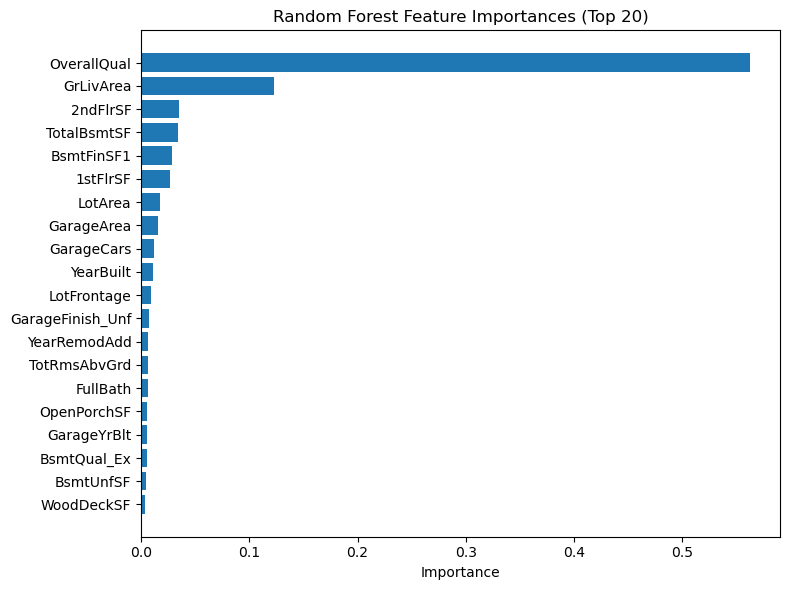

In [9]:
pre = best_rf_model.named_steps['preprocessor']
rf_reg = best_rf_model.named_steps['regressor']

onehot = pre.named_transformers_['cat'].named_steps['onehot']
cat_feature_names = onehot.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

importances = rf_reg.feature_importances_
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), all_feature_names[indices][::-1])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances (Top 20)')
plt.tight_layout()
plt.show()